# <center> Machine Learning & Deep Learning </center>

#### <center> *Exam: KAN-CDSCO2004U* </center>

---

In [1]:
import os
import itertools
import shutil
import random

import numpy as np
import pandas as pd
import seaborn as sns


import polars as pl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, recall_score

from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.preprocessing import OneHotEncoder

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

# 1. **Exploratory Data Analysis**

In [2]:
test_metadata = pd.read_csv('/Users/lassestrandbygaard/msc-data-science/ml-exam-project/test-metadata.csv')
train_metadata = pd.read_csv('/Users/lassestrandbygaard/msc-data-science/ml-exam-project/train-metadata.csv')

In [3]:
test_metadata.head()

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [4]:
train_metadata.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [5]:
# find unique values for patient_id
train_metadata['patient_id'].nunique()

1042

In [6]:
# Find how many unique patiants are male/female
train_metadata['patient_id'].groupby(train_metadata['sex']).nunique()

sex
female    458
male      551
Name: patient_id, dtype: int64

In [7]:
# Find how many unique patiants are benign/malignant
train_metadata['patient_id'].groupby(train_metadata['target']).nunique()

target
0    1041
1     259
Name: patient_id, dtype: int64

In [8]:
# Find how many unique patients are tested malignant/benign per sex
train_metadata['patient_id'].groupby([train_metadata['target'], train_metadata['sex']]).nunique()

target  sex   
0       female    458
        male      550
1       female     92
        male      159
Name: patient_id, dtype: int64

In [9]:
# make pivot table to find the number of unique patients that are tested malignant/benign and group by sex
cleaned = train_metadata.copy()

# Drop duplicates at patient_id + target level
cleaned = cleaned.drop_duplicates(subset=['patient_id', 'target'])

# Now pivot
pivot_table = cleaned.pivot_table(
    index='target',
    columns='sex',
    values='patient_id',
    aggfunc='nunique',
    margins=True
)
pivot_table

sex,female,male,All
target,,,
0,458,550,1008
1,92,159,251
All,458,551,1009


In [10]:
benign_patients = set(train_metadata.loc[train_metadata['target'] == 0, 'patient_id'])
malignant_patients = set(train_metadata.loc[train_metadata['target'] == 1, 'patient_id'])

In [11]:
# -------------------------------
# 1. Create sex + target subsets
# -------------------------------
male_benign_patients = set(train_metadata.loc[
    (train_metadata['target'] == 0) & (train_metadata['sex'] == 'male'), 'patient_id'])

female_benign_patients = set(train_metadata.loc[
    (train_metadata['target'] == 0) & (train_metadata['sex'] == 'female'), 'patient_id'])

male_malignant_patients = set(train_metadata.loc[
    (train_metadata['target'] == 1) & (train_metadata['sex'] == 'male'), 'patient_id'])

female_malignant_patients = set(train_metadata.loc[
    (train_metadata['target'] == 1) & (train_metadata['sex'] == 'female'), 'patient_id'])

nan_benign_patients = set(train_metadata.loc[
    (train_metadata['target'] == 0) & (train_metadata['sex'].isna()), 'patient_id'])
nan_malignant_patients = set(train_metadata.loc[
    (train_metadata['target'] == 1) & (train_metadata['sex'].isna()), 'patient_id'])

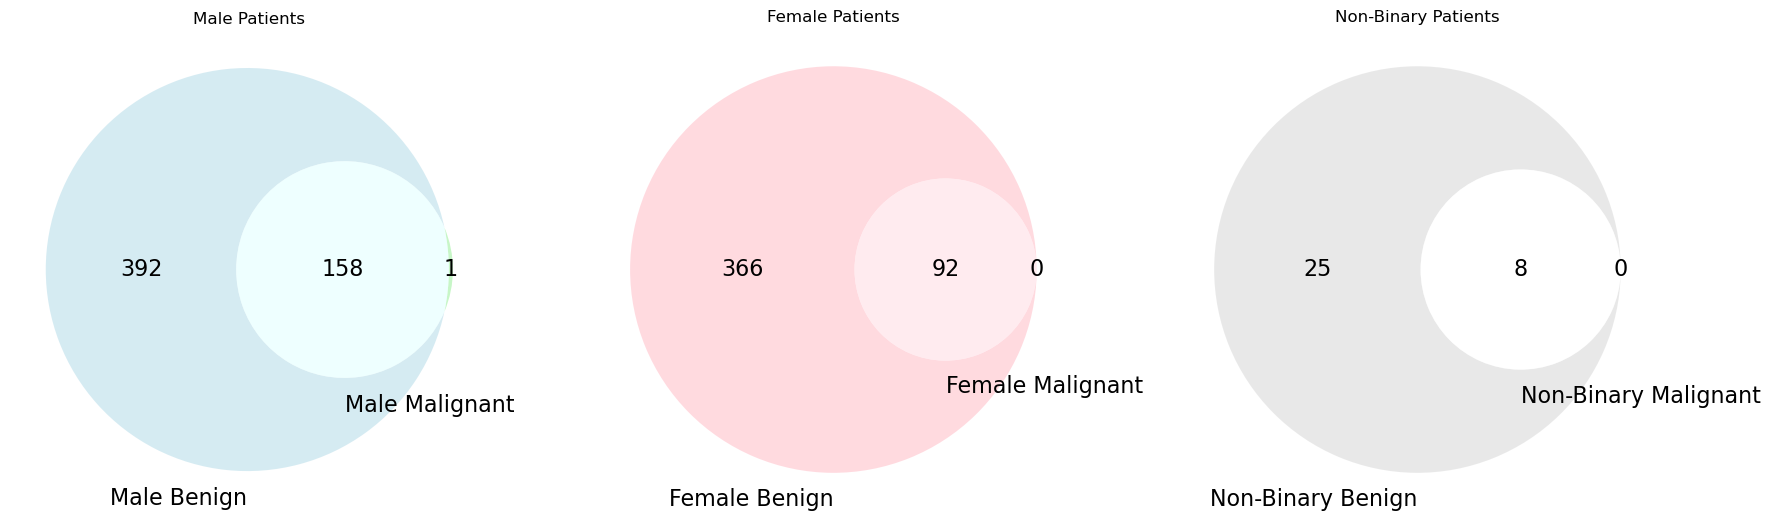

In [12]:
# -------------------------------
# 2. Venn diagrams
# -------------------------------
plt.figure(figsize=(18, 6))

# Male
plt.subplot(1, 3, 1)
venn = venn2((male_benign_patients, male_malignant_patients),
             set_labels=('Male Benign', 'Male Malignant'),
             set_colors=('lightblue', 'lightgreen'),
             alpha=0.5)
for text in venn.set_labels:
    if text: text.set_fontsize(16)
for text in venn.subset_labels:
    if text: text.set_fontsize(16)
plt.title('Male Patients')

# Female
plt.subplot(1, 3, 2)
venn = venn2((female_benign_patients, female_malignant_patients),
             set_labels=('Female Benign', 'Female Malignant'),
             set_colors=('lightpink', 'lightcoral'),
             alpha=0.5)
for text in venn.set_labels:
    if text: text.set_fontsize(16)
for text in venn.subset_labels:
    if text: text.set_fontsize(16)
plt.title('Female Patients')

# Non-Binary / Unknown
plt.subplot(1, 3, 3)
venn = venn2((nan_benign_patients, nan_malignant_patients),
             set_labels=('Non-Binary Benign', 'Non-Binary Malignant'),
             set_colors=('lightgray', 'lightyellow'),
             alpha=0.5)
for text in venn.set_labels:
    if text: text.set_fontsize(16)
for text in venn.subset_labels:
    if text: text.set_fontsize(16)
plt.title('Non-Binary Patients')

plt.tight_layout()
plt.show()



In [13]:
# -------------------------------
# 3. Identify missing patients
# -------------------------------

# All unique patient IDs
all_patients = set(train_metadata['patient_id'].unique())

# Patients shown in Venn diagrams
venn_patients = male_benign_patients | male_malignant_patients | female_benign_patients | female_malignant_patients

# Patients not shown
missing_patients = all_patients - venn_patients
print(f"Total patients: {len(all_patients)}")
print(f"Patients shown in Venns: {len(venn_patients)}")
print(f"Missing patients: {len(missing_patients)}")

# View missing patient details
missing_df = train_metadata[train_metadata['patient_id'].isin(missing_patients)]
display(missing_df)

Total patients: 1042
Patients shown in Venns: 1009
Missing patients: 33


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
57,ISIC_0073511,0,IP_3371534,NaN,NaN,lower extremity,4.17,TBP tile: close-up,3D: XP,26.849594,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
60,ISIC_0073555,0,IP_3371534,NaN,NaN,posterior torso,2.76,TBP tile: close-up,3D: XP,24.376506,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999642
63,ISIC_0073672,0,IP_6187331,55.0,NaN,lower extremity,3.00,TBP tile: close-up,3D: XP,16.715690,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999870
72,ISIC_0073934,0,IP_9472195,55.0,NaN,lower extremity,2.60,TBP tile: close-up,3D: XP,18.151000,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.996710
132,ISIC_0076435,0,IP_2914511,30.0,NaN,posterior torso,3.20,TBP tile: close-up,3D: XP,18.059761,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400728,ISIC_9992252,0,IP_7703522,40.0,NaN,lower extremity,2.60,TBP tile: close-up,3D: XP,27.126110,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
400826,ISIC_9994379,0,IP_1822913,35.0,NaN,anterior torso,7.70,TBP tile: close-up,3D: XP,17.586138,...,IL_3379145,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999630
400844,ISIC_9994715,0,IP_0473747,55.0,NaN,posterior torso,2.60,TBP tile: close-up,3D: XP,22.361158,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.929130
400983,ISIC_9998324,0,IP_1474479,70.0,NaN,posterior torso,9.10,TBP tile: close-up,3D: XP,17.787655,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.997973


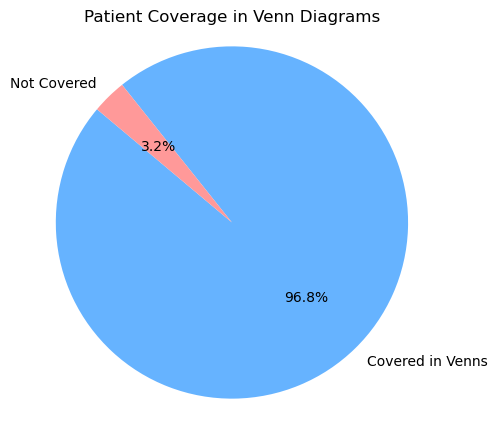

In [14]:
# -------------------------------
# 4. Optional: Pie chart overview
# -------------------------------
labels = ['Covered in Venns', 'Not Covered']
sizes = [len(venn_patients), len(missing_patients)]
colors = ['#66b3ff', '#ff9999']

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Patient Coverage in Venn Diagrams')
plt.axis('equal')
plt.show()

In [15]:
# find how many of the malignant are of the same patient id
train_metadata[train_metadata['target'] == 1].groupby('patient_id').nunique()['target'].value_counts()

target
1    259
Name: count, dtype: int64

### 2. Preprocessing

#### **2.1. Split images into 'Benign' and 'Malignant'**

In [16]:

# === Load Metadata ===
#full_metadata_path = "'/Users/lassestrandbygaard/msc-data-science/train-metadata.csv'"

#full_metadata_df = pd.read_csv(full_metadata_path)

# Create the directory for the minority class images if it doesn't exist
os.makedirs("dataset/train/malignant", exist_ok=True)

image_dir = "Original Dataset - All Images"

# Move the images to the new folder
for img_id in train_metadata[train_metadata["target"] == 1]["isic_id"]:
    src_path = os.path.join(image_dir, f"{img_id}.jpg")
    dst_path = os.path.join("dataset/train/malignant", f"{img_id}.jpg")
    if os.path.exists(src_path):
        os.rename(src_path, dst_path)  # Move the file to the new location
    else:
        print(f"File {src_path} does not exist.")

os.rename("Original Dataset - All Images", "dataset/train/benign")  # Rename the benign folder

File Original Dataset - All Images/ISIC_0082829.jpg does not exist.
File Original Dataset - All Images/ISIC_0096034.jpg does not exist.
File Original Dataset - All Images/ISIC_0104229.jpg does not exist.
File Original Dataset - All Images/ISIC_0119495.jpg does not exist.
File Original Dataset - All Images/ISIC_0157834.jpg does not exist.
File Original Dataset - All Images/ISIC_0190307.jpg does not exist.
File Original Dataset - All Images/ISIC_0211092.jpg does not exist.
File Original Dataset - All Images/ISIC_0220459.jpg does not exist.
File Original Dataset - All Images/ISIC_0238218.jpg does not exist.
File Original Dataset - All Images/ISIC_0275647.jpg does not exist.
File Original Dataset - All Images/ISIC_0279372.jpg does not exist.
File Original Dataset - All Images/ISIC_0287900.jpg does not exist.
File Original Dataset - All Images/ISIC_0293670.jpg does not exist.
File Original Dataset - All Images/ISIC_0321944.jpg does not exist.
File Original Dataset - All Images/ISIC_0330452.

FileNotFoundError: [Errno 2] No such file or directory: 'Original Dataset - All Images' -> 'dataset/train/benign'

#### **2.2. Split into train, validation, and test datasets**

In [ ]:
DATA_DIR = "dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
#os.makedirs(TRAIN_DIR, exist_ok=True)

VAL_DIR = os.path.join(DATA_DIR, "validation")
os.makedirs(VAL_DIR, exist_ok=True)

TEST_DIR = os.path.join(DATA_DIR, "test")
os.makedirs(TEST_DIR, exist_ok=True)

In [ ]:
VAL_RATIO = 0.15
TEST_RATIO = 0.15
SEED = 42

random.seed(SEED)

for split_dir in [VAL_DIR, TEST_DIR]:
    for class_name in os.listdir(TRAIN_DIR):
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

for class_name in os.listdir(TRAIN_DIR):
    class_path = os.path.join(TRAIN_DIR, class_name)
    files = [f for f in os.listdir(class_path)]
    random.shuffle(files)

    n_total = len(files)
    n_val = int(n_total * VAL_RATIO)
    n_test = int(n_total * TEST_RATIO)

    val_files = files[:n_val]
    test_files = files[n_val:n_val + n_test]

    # Move to val
    for fname in val_files:
        src = os.path.join(class_path, fname)
        dst = os.path.join(VAL_DIR, class_name, fname)
        shutil.move(src, dst)

    # Move to test
    for fname in test_files:
        src = os.path.join(class_path, fname)
        dst = os.path.join(TEST_DIR, class_name, fname)
        shutil.move(src, dst)

    print(f"{class_name}: Moved {n_val} to val, {n_test} to test. Remaining in train: {n_total - n_val - n_test}")

#### **2.3. Image Augmentation**

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img, save_img

In [18]:
# Define the augmentation
datagen = ImageDataGenerator(
    rotation_range=90,             # Random rotation
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.15,
    brightness_range=[0.7, 1.4],   # Vary lighting
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'         # Fill mode for new pixels
)

In [ ]:
# Load all images from minority class
minority_class_train_dir = '/Users/lassestrandbygaard/msc-data-science/Exam Project/Solution Dataset'

images = [f for f in os.listdir(minority_class_train_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

for iter, img_name in enumerate(images):
    img_path = os.path.join(minority_class_train_dir, img_name)
    img = load_img(img_path, target_size=(224, 224))  # or your image size
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)  # Reshape for ImageDataGenerator

    # Extract the ISIC ID from the filename. filename has format: ISIC_0000001.jpg
    isic_id = os.path.splitext(img_name)[0]

    # Generate 15 augmented images per original
    i = 0
    for batch in datagen.flow(
        x,
        batch_size=1,
        save_to_dir=None,  # Do not save directly to the directory
        save_format='jpg'
    ):
        i += 1
        # Construct the new filename
        new_filename = f"{isic_id}_aug_{i}.jpg"
        new_path = os.path.join(minority_class_train_dir, new_filename)

        # Save the augmented image manually
        save_img(new_path, batch[0])  # Save the first (and only) image in the batch

        if i >= 15:
            break  # Generate 15 images per original
    
    print(f"Generated: {(iter+1)*15}/{len(images)*15} images")  # Print the progress

# When done, check the number of images in the augmented folder
print(f"There are now {len(os.listdir(minority_class_train_dir))} images in the train/malignant folder.")

## 1. Tabular Data

#### **1.1. Imports and Function Definitions**

In [19]:
_df_train = pd.read_csv("/Users/lassestrandbygaard/msc-data-science/ml-exam-project/train-metadata.csv")
_df_test = pd.read_csv("/Users/lassestrandbygaard/msc-data-science/ml-exam-project/test-metadata.csv")

In [20]:
train_path = 'train-metadata.csv'
test_path = '/test-metadata.csv'

id_col = 'isic_id'
target_col = 'target'
group_col = 'patient_id'

err = 1e-5
sampling_ratio = 0.01
seed = 42

In [21]:
num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+ 
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]

In [22]:
new_num_cols = [
    'lesion_size_ratio',             # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',            # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                  # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',            # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',       # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt  
    'border_complexity',             # tbp_lv_norm_border      + tbp_lv_symm_2axis
    'color_uniformity',              # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',          # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',       # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',       # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',       # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',   # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',   # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',             # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',             # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',          # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',     # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',         # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',        # border_complexity       + lesion_shape_index
    'color_contrast_index',          # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',               # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',        # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',           # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',              # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',   # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',         # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',      # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',# tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',    # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',          # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',      # tbp_lv_norm_border      * tbp_lv_norm_color
    'border_color_interaction_2',
    'size_color_contrast_ratio',     # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',# tbp_lv_nevi_confidence  / age_approx
    'age_normalized_nevi_confidence_2',
    'color_asymmetry_index',         # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',       # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                   # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',       # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',           # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',       # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',       # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
]

In [23]:
cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']
norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
special_cols = ['count_per_patient'] + [f'{col}_count' for col in cat_cols] + [(f'{num_col}_{cat_col}') for num_col, cat_col in itertools.product(num_cols, cat_cols)]
feature_cols = num_cols + new_num_cols + cat_cols + norm_cols + special_cols

In [24]:
def load_data(df):
    return (
        df
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )

        # Fill all NaNs in float columns with their median
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()),
        )

        # Fill all NaNs in categorical columns with their most frequent value
        .with_columns(
            pl.col(pl.Categorical).fill_nan(pl.col(pl.Categorical).mode()),
        )
        
        # First batch of feature engineering
        .with_columns(
            lesion_size_ratio           = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index          = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast          = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference     = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity           = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity            = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + 1e-8),
        )

        # Second batch of derived geometrical/color features
        .with_columns(
            position_distance_3d        = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio     = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio     = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score     = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site    = pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border') + 1e-8),
        )

        # More color and interaction indices
        .with_columns(
            color_consistency           = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color           = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext') + 1e-8),
            size_age_interaction        = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction   = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index       = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index      = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index        = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )

        # Log and mean derived measurements
        .with_columns(
            log_lesion_area             = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size      = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference         = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast            = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d       = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference    = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )

        # Final group of compound indices
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + 1e-8),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )

        # Final geometry and shape features
        .with_columns(
            volume_approximation_3d     = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                 = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency     = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio         = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index     = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry     = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )

        # Patient-level z-score normalization
        .with_columns([
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + 1e-8)).alias(f'{col}_patient_norm')
            for col in (num_cols + new_num_cols)
        ])

        # Patient + category normalization
        .with_columns([
            ((pl.col(num_col) - pl.col(num_col).mean().over('patient_id', cat_col)) /
             (pl.col(num_col).std().over('patient_id', cat_col) + 1e-8)).alias(f'{num_col}_{cat_col}')
            for num_col, cat_col in itertools.product(num_cols, cat_cols)
        ])

        # Count features per group
        .with_columns([
            pl.col(col).count().over('patient_id', col).alias(f'{col}_count') for col in cat_cols
        ])

        # Count total samples per patient
        .with_columns(
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )

        # Cast all categorical columns
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )

        # Convert to pandas and set index
        .to_pandas()
        .set_index(id_col)
    )

In [25]:
def preprocess(df_train, df_test):
    """
    Preprocess the data by applying one-hot encoding to categorical features.
    """
    global cat_cols
    
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])
    
    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols
    
    return df_train, df_test

In [26]:
def custom_metric(estimator, X, y_true):
    """
    Custom metric function to calculate the partial AUC.
    """
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

#### **1.2. Loading Data And Feature Engineering**

In [27]:
# check numopy version
print(np.__version__)

1.24.4


In [28]:
df_train = load_data(pl.from_pandas(_df_train))
df_test = load_data(pl.from_pandas(_df_test))

In [29]:
df_train, df_test = preprocess(df_train, df_test)

In [30]:
# check which columns have NaN values
len(df_train.columns[df_train.isna().any()].tolist())

297

In [31]:
# show the shapoe of the data
df_train.shape, df_test.shape

((401059, 431), (3, 420))

In [32]:
# Deduplicate exact rows (based on all columns except the target)
df_train_dedup = df_train.drop_duplicates()

# Now split with no risk of duplicates leaking across sets
df_train_final, df_temp = train_test_split(
    df_train_dedup, test_size=0.30, random_state=42, stratify=df_train_dedup[target_col]
)

df_val, df_test_final = train_test_split(
    df_temp, test_size=0.50, random_state=42, stratify=df_temp[target_col]
)

In [33]:
df_train_final.shape, df_val.shape, df_test_final.shape

((280741, 431), (60159, 431), (60159, 431))

In [34]:
df_train_final['target'].value_counts()

target
0    280466
1       275
Name: count, dtype: int64

In [35]:
df_test_final['target'].value_counts()

target
0    60100
1       59
Name: count, dtype: int64

In [36]:
df_val['target'].value_counts()

target
0    60100
1       59
Name: count, dtype: int64

#### **1.3. HyperParameter Tuned Models**

In [37]:
sampling_ratio = 0.01
seed = 42

# Parameters for the light gradient boosting model
lgb_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'n_iter':           200,
    'n_jobs':           2,
    'boosting_type':    'gbdt',
    'lambda_l1':        0.03335206514282942, 
    'lambda_l2':        0.005157393323802471, 
    'learning_rate':    0.030665870185795318, 
    'max_depth':        7, 
    'num_leaves':       239, 
    'colsample_bytree': 0.7573175155547233, 
    'colsample_bynode': 0.5005423904042993, 
    'bagging_fraction': 0.7937347683420382, 
    'bagging_freq':     4, 
    'min_data_in_leaf': 29, 
    'scale_pos_weight': 1.648349898918236,
}

# Parameters for the CatBoost model
cat_params = {
    'loss_function':     'Logloss',
    'iterations':        250,
    'verbose':           False,
    'random_state':      32,
    'max_depth':         7, 
    'learning_rate':     0.06936242010150652, 
    'scale_pos_weight':  2.6149345838209532, 
    'l2_leaf_reg':       6.216113851699493, 
    'subsample':         0.6249261779711819, 
    'min_data_in_leaf':  24,
    'cat_features':      cat_cols,
}

# Parameters for the XGBoost model
xgb_params = {
    'enable_categorical': True,
    'tree_method':        'hist',
    'random_state':       42,
    'learning_rate':      0.08501257473292347, 
    'lambda':             8.879624125465703, 
    'alpha':              0.6779926606782505, 
    'max_depth':          6, 
    'subsample':          0.6012681388711075, 
    'colsample_bytree':   0.8437772277074493, 
    'colsample_bylevel':  0.5476090898823716, 
    'colsample_bynode':   0.9928601203635129, 
    'scale_pos_weight':   3.29440313334688,
}

In [38]:
# ========== Preprocessing for LGBM and XGBoost ==========
categorical_transformer_common = SklearnPipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_common = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', categorical_transformer_common, cat_cols)
])

# ========== Custom DataFrame Wrapper for CatBoost ==========
class DataFrameWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(X, columns=self.columns)

# ========== Preprocessing for CatBoost (No OneHotEncoding) ==========
catboost_transformer = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', SimpleImputer(strategy='most_frequent'), cat_cols)
])

preprocessor_catboost = SklearnPipeline([
    ('transformer', catboost_transformer),
    ('to_df', DataFrameWrapper(columns=num_cols + cat_cols))
])

In [39]:
lgb_model = Pipeline([
    ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=22)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=22)),
    ('classifier', lgb.LGBMClassifier(**lgb_params)),
])

cat_model = Pipeline([
    ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=32)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=32)),
    ('classifier', CatBoostClassifier(**cat_params)),
])

xgb_model = Pipeline([
    ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=seed)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('classifier', xgb.XGBClassifier(**xgb_params))
])

# ========== LightGBM pipeline with SMOTE==========
lgb_model_smote = Pipeline([
    ('preprocessor', preprocessor_common),
    ('sampler_1', SMOTE(sampling_strategy=0.003, random_state=22)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=22)),
    ('classifier', lgb.LGBMClassifier(**lgb_params))
])

# ========== XGBoost pipeline WITH SMOTE ==========
xgb_model_smote = Pipeline([
    ('preprocessor', preprocessor_common),
    ('sampler_1', SMOTE(sampling_strategy=0.003, random_state=seed)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('classifier', xgb.XGBClassifier(**xgb_params))
])

In [40]:
estimator = VotingClassifier([
    ('lgb', lgb_model_smote),
    ('cat', cat_model),
    ('xgb', xgb_model_smote)
], voting='soft')

#### **1.4. Cross Validation**

In [41]:
X = df_train_final[feature_cols]
y = df_train_final[target_col]
groups = df_train_final[group_col]
cv = StratifiedGroupKFold(5, shuffle=True, random_state=seed)

In [42]:
val_score = cross_val_score(
    estimator=estimator, 
    X=X, y=y, 
    cv=cv, 
    groups=groups,
    scoring=custom_metric,
)

np.mean(val_score), val_score

(0.17192011336777532,
 array([0.17395864, 0.17716258, 0.18195657, 0.17515734, 0.15136544]))

In [43]:
X, y = df_train_final[feature_cols], df_train_final[target_col]

Ensemble_model = estimator.fit(X, y) # Otherwise delete "Ensemble_model = " and use the model directly

#### **1.5. Classification Report & Confusion Matrix**

In [44]:
# get classification report on the test set 
X_test = df_test_final[feature_cols]
y_test = df_test_final[target_col]
groups_test = df_test_final[group_col]

In [45]:
y_pred = Ensemble_model.predict(X_test)
y_pred_proba = Ensemble_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")
print(f"Partial AUC: {custom_metric(Ensemble_model, X_test, y_test)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60100
           1       0.31      0.14      0.19        59

    accuracy                           1.00     60159
   macro avg       0.65      0.57      0.59     60159
weighted avg       1.00      1.00      1.00     60159

ROC AUC: 0.9667816351278942
Partial AUC: 0.1739929496037677


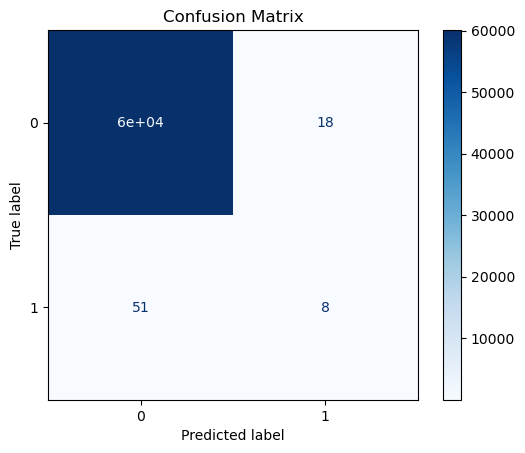

In [46]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimator.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

---

# **2. Image Data**

### *Upgrade tensorflow to version 3 before continuing*

## **2.1. CNN**

In [2]:
img_size = (133, 133)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/lassestrandbygaard/msc-data-science/ml-exam-project/Solution Dataset/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/lassestrandbygaard/msc-data-science/ml-exam-project/Solution Dataset/val",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)

# Load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/lassestrandbygaard/msc-data-science/ml-exam-project/Solution Dataset/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)

Found 284900 files belonging to 2 classes.
Found 60157 files belonging to 2 classes.
Found 60157 files belonging to 2 classes.


In [4]:
# Check nummpy version
print(np.__version__)

1.24.4


In [3]:
def cnn_preprocess_fn(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

### **WARNING: DO NOT RUN THE CODE BELOW AS IT WILL USE UP ALL RAM FOR THE 400k IMAGES**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE # Prefetch the datasets for performance. This allows the data loading of the next batch to be done in parallel with model training from the current batch.

# Preprocess the datasets for CNN. Caching on disk.
CNN_train_ds = train_ds.map(cnn_preprocess_fn, num_parallel_calls=AUTOTUNE) \
                       .cache() \
                       .shuffle(1000) \
                       .prefetch(AUTOTUNE)

CNN_val_ds = val_ds.map(cnn_preprocess_fn, num_parallel_calls=AUTOTUNE) \
                       .cache() \
                       .prefetch(AUTOTUNE)

CNN_test_ds = test_ds.map(cnn_preprocess_fn, num_parallel_calls=AUTOTUNE) \
                       .cache() \
                       .prefetch(AUTOTUNE)

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import register_keras_serializable

In [77]:
# Define the model
CNN_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(133, 133, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
    ])

In [101]:
# Recompile the model
@register_keras_serializable()
def focal_loss(gamma=2.0, alpha=0.90):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        focal_weight = alpha_factor * K.pow((1 - p_t), gamma)
        return -K.mean(focal_weight * K.log(p_t))
    return loss

In [79]:
CNN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.90),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision', thresholds=0.5),
        tf.keras.metrics.Recall(name='recall', thresholds=0.5)
    ]
)

In [80]:
# Create a save folder path
os.makedirs("CNN", exist_ok=True)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
CNN_model_checkpoint = ModelCheckpoint(
    filepath='CNN/CNN_best_model.keras',
    save_weights_only=False,                  # Save the full model
    save_best_only=True,                     # Save just the best
    verbose=1
)

In [10]:
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 131, 131, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 65, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

### **WARNING: DO NOT RUN THE LINE BELOW TO AVOID LONG RUN TIME**

In [ ]:
# Train the model
CNN_model.fit(CNN_train_ds,
                    epochs=20,  
                    validation_data=CNN_val_ds,
                    verbose=1,
                    callbacks=[early_stopping, CNN_model_checkpoint])    
# Save the model
CNN_model.save('CNN/CNN_final_model.keras')  

In [11]:
# Load the model
CNN_model = load_model("CNN/CNN_final_model.h5", compile=False) # Can't compile because there's a custom loss function (focal loss)

In [ ]:


CNN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.75),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision', thresholds=0.5),
        tf.keras.metrics.Recall(name='recall', thresholds=0.5)
    ]
)

In [13]:
loss, accuracy, precision, recall = CNN_model.evaluate(test_ds, verbose=1)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

1880/1880 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.3281 - loss: 2.4394 - precision: 0.0012 - recall: 0.8697
Loss: 2.4439
Accuracy: 0.3272
Precision: 0.0013
Recall: 0.8966


In [15]:
# Fine-tune the classification threshold on the validation dataset


# Predictions and true labels
predictions = CNN_model.predict(val_ds).flatten()
true_classes = np.concatenate([y.numpy() for _, y in val_ds], axis=0)

# Thresholds to test
thresholds = np.arange(0.0, 1.001, 0.001)

recalls_class_0 = []
recalls_class_1 = []

# Evaluate each threshold
for thresh in thresholds:
    preds = (predictions >= thresh).astype(int)
    recall_per_class = recall_score(true_classes, preds, average=None, zero_division=0)
    recalls_class_0.append(recall_per_class[0])
    recalls_class_1.append(recall_per_class[1])


# Convert to arrays
recalls_class_0 = np.array(recalls_class_0)
recalls_class_1 = np.array(recalls_class_1)

# Find threshold where the difference in recall is minimized
recall_diff = np.abs(recalls_class_0 - recalls_class_1)
crossing_idx = np.argmin(recall_diff)
crossing_threshold = thresholds[crossing_idx]
recall0 = recalls_class_0[crossing_idx]
recall1 = recalls_class_1[crossing_idx]

# Print results
print(f"Crossing threshold: {crossing_threshold:.3f}")
print(f"Recall for class 0 (benign): {recall0:.4f}")
print(f"Recall for class 1 (malignant): {recall1:.4f}")

1880/1880 ━━━━━━━━━━━━━━━━━━━━ 66s 35ms/step


2025-05-16 09:10:17.121247: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Crossing threshold: 1.000
Recall for class 0 (benign): 0.4270
Recall for class 1 (malignant): 0.5862


In [17]:
# Make predictions on the test dataset
class_names = test_ds.class_names
predictions = CNN_model.predict(test_ds)
predicted_classes = (predictions > crossing_threshold).astype("int32")
true_classes = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

report = classification_report(true_classes, predicted_classes, target_names=class_names)

# Print classification report
print(report)

1880/1880 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00     60099
   malignant       0.00      0.00      0.00        58

    accuracy                           1.00     60157
   macro avg       0.50      0.50      0.50     60157
weighted avg       1.00      1.00      1.00     60157



2025-05-16 09:11:46.538915: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)

[[60099     0]
 [   58     0]]


NB: The results shown in this notebook is from the run we did on a MacBook M2 and not the actual results done on UCloud. We have uploaded our best training results too but here you can see the results for the CNN. Look at the other notebooks for getting the result for the ViT and the EfficientNetB0

In [109]:
# load tbe best results from the npy file on the confusion matrix
best_confusion_matrix = np.load('CNN_confusion_matrix_3.npy')
print(best_confusion_matrix)

[[48115 11984]
 [   14    44]]


In [110]:
# load the txt file with the best results
with open('/Users/lassestrandbygaard/msc-data-science/ml-exam-project/CNNbestResults.txt', 'r') as f:
    best_results = f.read()
print(best_results)

              precision    recall  f1-score   support

      benign       1.00      0.80      0.89     60099
   malignant       0.00      0.76      0.01        58

    accuracy                           0.80     60157
   macro avg       0.50      0.78      0.45     60157
weighted avg       1.00      0.80      0.89     60157

